In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import statsmodels
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
%matplotlib inline
from pmdarima.arima import auto_arima

In [3]:
# Carregando os dados:
df=pd.read_csv('sea_level.csv')
#reduzir dados
#df = df.iloc[inicio:fim]

# Carregando os dados:

df_sea=df.dropna()
df_sea= df_sea.set_index(['Year'])

df_sea.index = pd.to_datetime(df_sea.index, format='%Y')
df_sea = df_sea[['Sea Level']].groupby('Year').sum()
#df_sea.rename(columns={'Sea Level': 'Sea Level'}, inplace = True)

df_sea.head(10)


,Sea Level
Year,
1880-01-01,0.000000
1881-01-01,0.220472
1882-01-01,-0.440945
1883-01-01,-0.232283
1884-01-01,0.590551
1885-01-01,0.531496
1886-01-01,0.437008
1887-01-01,0.216535
1888-01-01,0.299213


In [4]:
df_sea.iloc[[0, -1]]

,Sea Level
Year,
1880-01-01,0.000000
2013-01-01,8.980315


In [5]:
# conhecendo os dados:
df_sea.head(1)

,Sea Level
Year,
1880-01-01,0.0


In [6]:
# conhecendo os dados:
df_sea.tail(1)

,Sea Level
Year,
2013-01-01,8.980315


In [7]:
# conhecendo os dados:
df_sea.info()
df_sea.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1880-01-01 to 2013-01-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Sea Level  134 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


,Sea Level
count,134.000000
mean,3.650341
std,2.485692
min,-0.440945
25%,1.632874
50%,3.312992
75%,5.587598
max,9.326772


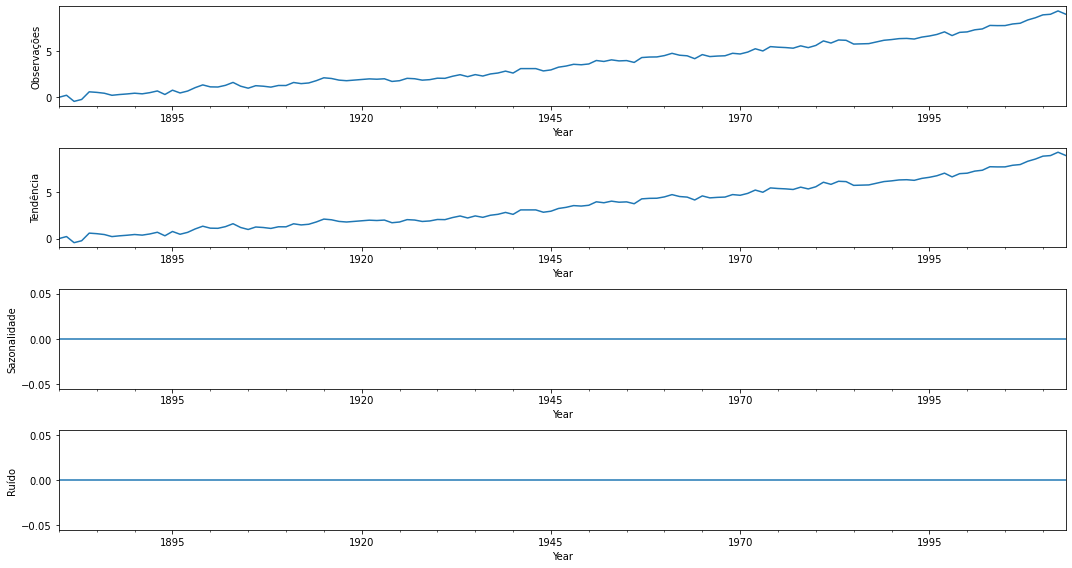

In [8]:
# decompondo a série

seasonplot = seasonal_decompose(df_sea)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1, ylabel='Observações') 
seasonplot.trend.plot(ax=ax2, ylabel='Tendência') 
seasonplot.seasonal.plot(ax=ax3, ylabel='Sazonalidade')
seasonplot.resid.plot(ax=ax4, ylabel='Ruído') 
plt.tight_layout()


In [9]:
# aplicando o teste Dickey-Fuller Aumentado (ADF) para verificar estacionariedade na série:

# Extraindo a coluna que contém os dados da série temporal
dados_serie = df_sea['Sea Level']
resultado_adf = adfuller(dados_serie)

# Extraindo os resultados do teste ADF
valor_p = resultado_adf[1]
estatistica_teste = resultado_adf[0]

# Comparando o valor-p com um nível de significância (geralmente 0.05)
nivel_de_significancia = 0.05

if valor_p <= nivel_de_significancia:
    print("A série temporal é estacionária (rejeita-se a hipótese nula).")
else:
    print("A série temporal não é estacionária (não se rejeita a hipótese nula).")

# Exiba a estatística do teste
print(f"Estatística do teste ADF: {estatistica_teste}")
print(f"Valor-p: {valor_p}")

A série temporal não é estacionária (não se rejeita a hipótese nula).
Estatística do teste ADF: 1.4210821193704959
Valor-p: 0.9972078414167472


In [10]:
# em caso negativo, para teste do melhor resultado da série para se tornar estacionária, pode ser aplicado a diferenciação:
diff_1 = dados_serie.diff().dropna()
# testar novamente por ADF
dados_serie = diff_1
resultado_adf = adfuller(dados_serie)

# Extraindo os resultados do teste ADF
valor_p = resultado_adf[1]
estatistica_teste = resultado_adf[0]

# Comparando o valor-p com um nível de significância (geralmente 0.05)
nivel_de_significancia = 0.05

if valor_p <= nivel_de_significancia:
    print("A série temporal é estacionária (rejeita-se a hipótese nula).")
else:
    print("A série temporal não é estacionária (não se rejeita a hipótese nula).")

# Exiba a estatística do teste
print(f"Estatística do teste ADF: {estatistica_teste}")
print(f"Valor-p: {valor_p}")

A série temporal é estacionária (rejeita-se a hipótese nula).
Estatística do teste ADF: -15.148184710300258
Valor-p: 6.856956707463201e-28


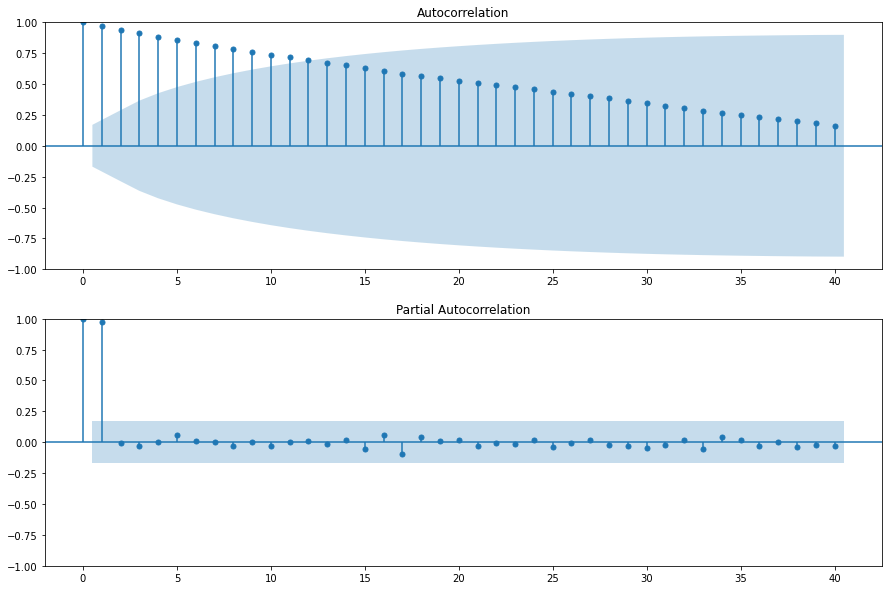

In [11]:
# verificando autocorrelação e autocorrelação parcial:
# auto-regressão (p) = autorrelação; média móvel (q)= autocorrelação parcial.
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,10))
sm.graphics.tsa.plot_acf(df_sea.values.squeeze(), lags=40, ax=ax1)
sm.graphics.tsa.plot_pacf(df_sea.values.squeeze(), lags= 40, ax=ax2, method='ywm')
plt.show()

In [12]:
# Aplicando método Auto ARIMA (já pode-se definir max e min valores dos parâmetros para facilitar o código):
# A sazonalidade, se mensal, usar m=12; Por padrão o P iniciará em 0 e o máximo será 2; o Q por padrão será 1 e o máximo, por padrão, será 2; o d será 1 e o máximo, por padrão, será 2; o D será 1, por padrão já é 1.
# Serão gerados vários modelos ARIMA e os seus respectivos AIC's e BICS (critérios de informação).
# Stepwise permite diminuir o número de modelos gerados, deixa o código mais leve.
stepwise=auto_arima(df_sea,start_p=0, start_q=0,max_p=3,max_q=2,start_P=0,
                     seasonal=False,trace=True, error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.028, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.182, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26.629, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3.749, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-25.833, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-25.869, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22.630, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-5.780, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.830 seconds


In [13]:
# verificando resultado e menor AIC:
stepwise

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [14]:
stepwise.aic()

-26.629300105615997

In [16]:
# testando mais um modelo, com parâmetro diferente, por exemplo de sazonalidade D:
stepwise1=auto_arima(df_sea,start_p=0, start_q=0,max_p=5,max_q=5,start_P=0,m=12,
                     seasonal=False,D=1,d=1,trace=True,error_action='ignore',suppress_warnings=True,stepwise=False)

/home/julia/.local/lib/python3.10/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13.028, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-26.629, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-25.869, Time=0.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-23.904, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-22.385, Time=0.39 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-20.982, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-22.182, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-25.833, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-22.630, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-22.491, Time=0.29 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-21.182, Time=0.55 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-23.951, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-23.918, Time=0.20 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-23.190, Time=0.38 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-24.425, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0] i

In [47]:
# Agora que sabemos os melhores parâmetros, vamos criar um modelo SARIMAX 
# (versão do arima com parametros para sazonalidade)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_sea,order=(0,1,1),  seasonal_order=(0, 0,0, 0))
resultado_sarimax = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10
 This problem is unconstrained.

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.08691D-02    |proj g|=  7.10439D-01

At iterate    5    f= -3.64182D-02    |proj g|=  4.20793D-02

At iterate   10    f= -3.64940D-02    |proj g|=  1.79078D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     13      1     0     0   1.791D-06  -3.649D-02
  F =  -3.6494020292309359E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [48]:
# resultados do modelo SARIMAX(2,1,2)
resultado_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Sea Level   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood                   4.890
Date:                Tue, 23 Jan 2024   AIC                             -5.780
Time:                        19:19:52   BIC                              0.000
Sample:                    01-01-1880   HQIC                            -3.431
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1678      0.096     -1.743      0.081      -0.356       0.021
sigma2         0.0544      0.006      9.003      0.000       0.043       0.066
===================================================================================
Ljung-Box (L1) (Q):                   3.12   Jarque-Bera (JB):                 2.86
Prob(Q):                              0.08   Prob(JB):                         0.24
Heteroskedasticity (H):               0.88   Skew:                            -0.06
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
# Vamos realizar um "backtesting" com predições de valores dos 12 meses anteriores
predicoes = resultado_sarimax.get_prediction(start=-12)
predicao_media = predicoes.predicted_mean

In [56]:
# intervalo de confiança

intervalo_confianca = predicoes.conf_int()
limites_abaixo = intervalo_confianca.iloc[:,0]
limites_acima = intervalo_confianca.iloc[:,1]

limites_abaixo[0], limites_acima[0]

(6.789879906450438, 7.704028486890063)

In [57]:
predicao_media[0]

7.24695419667025

In [58]:
datas_previsao = np.asarray(predicao_media.index)
datas = np.asarray(df_sea.index)

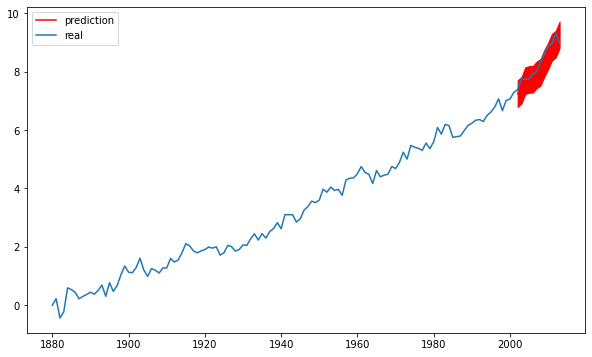

In [60]:
plt.figure(figsize=(10,6))
plt.plot(datas_previsao,predicao_media.values,color='red',label='prediction')
plt.fill_between(datas_previsao, limites_abaixo, limites_acima, color='red')
plt.plot(datas, df_sea.values, label='real')
plt.legend()
plt.show()

In [130]:
# verificando demais resultados com menores AIC:
stepwise1
stepwise1.aic()

6.109699495191208

In [17]:
# validar modelo
# separando os dados de treino e teste: os dados de treino (70% inicial da amostra) serão usado para treinar o modelo ARIMA e os dados de teste(30% restante) para comparar com as previsões geradas.

train=df_sea.loc['1880-01-01':'2000-01-01']
test=df_sea.loc['2000-02-01':]

In [18]:
stepwise.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [19]:
stepwise1.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [20]:
# calculando previsões para n periodos futuros:
future_forecast=stepwise.predict(n_periods=24)

In [21]:
future_forecast1=stepwise1.predict(n_periods=24)

In [22]:
future_forecast=pd.DataFrame(future_forecast,index=test.index, columns=['previsão modelo 1'])

In [23]:
future_forecast1=pd.DataFrame(future_forecast1,index=test.index, columns=['previsão modelo 2'])

In [24]:
future_forecast.head(10)

,previsão modelo 1
Year,
2001-01-01,7.090206
2002-01-01,7.149168
2003-01-01,7.208130
2004-01-01,7.267093
2005-01-01,7.326055
2006-01-01,7.385017
2007-01-01,7.443979
2008-01-01,7.502941
2009-01-01,7.561903


In [25]:
future_forecast1.head(10)

,previsão modelo 2
Year,
2001-01-01,7.090206
2002-01-01,7.149168
2003-01-01,7.208130
2004-01-01,7.267093
2005-01-01,7.326055
2006-01-01,7.385017
2007-01-01,7.443979
2008-01-01,7.502941
2009-01-01,7.561903


<Figure size 1440x360 with 0 Axes>

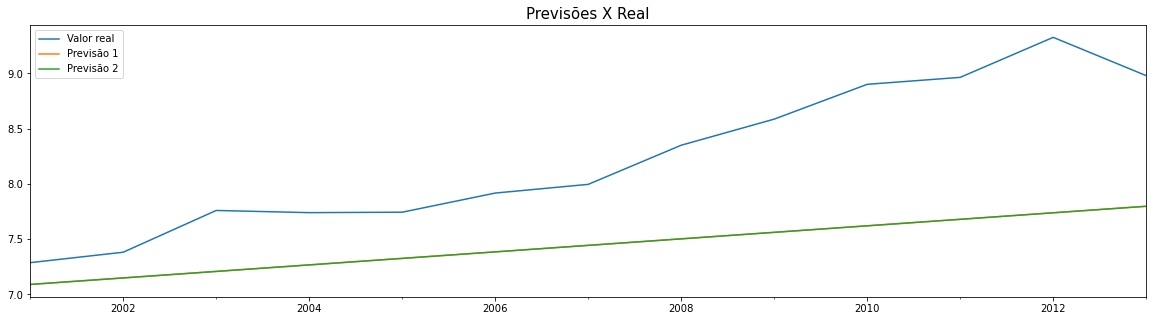

In [26]:
plt.figure(figsize=(20,5))
pd.concat([test,future_forecast, future_forecast1],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.legend(['Valor real','Previsão 1', 'Previsão 2'])
plt.show();

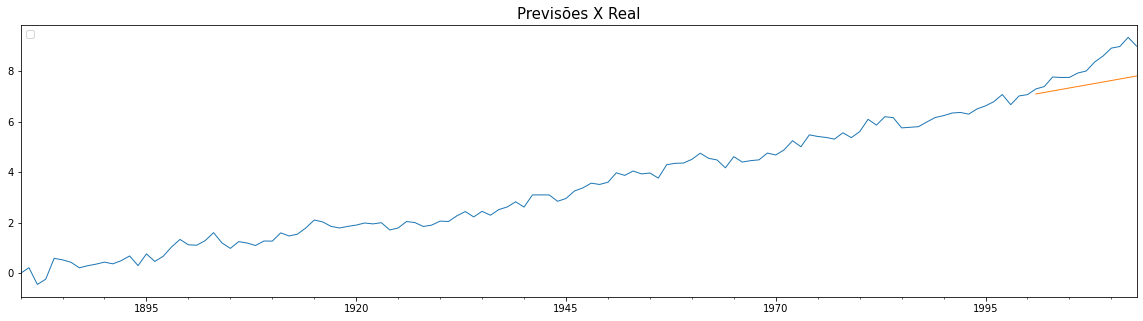

In [27]:
pd.concat([df_sea,future_forecast],axis=1).plot(linewidth=1,figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

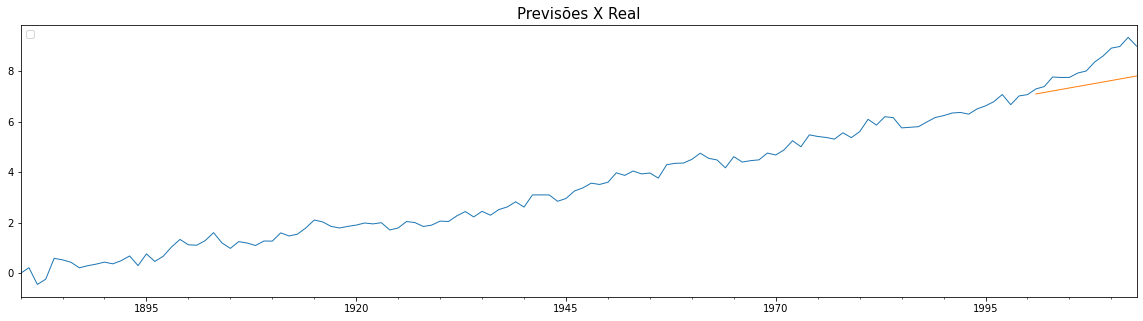

In [28]:
pd.concat([df_sea,future_forecast1],axis=1).plot(linewidth=1, figsize=(20,5))
plt.legend('')
plt.xlabel('')
plt.title('Previsões X Real',size=15)
plt.show();

In [29]:
# função para calcular o erro dos modelos
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

def check_erro(orig, prev, nome_col='', nome_indice=''):
    
    vies = np.mean(orig - prev)
    mse = mean_squared_error(orig, prev)
    rmse = sqrt(mean_squared_error(orig, prev))
    mae = mean_absolute_error(orig, prev)
    mape = np.mean(np.abs((orig - prev) / orig)) * 100
    
    grupo_erro = [vies, mse, rmse, mae, mape]
    serie = pd.DataFrame(grupo_erro, index=['VIÉS','MSE','RMSE','MAE', 'MAPE'], columns=[nome_col])
    serie.index.name = nome_indice
    
    return serie

In [30]:
# Análise dos erros/resíduos, ideal é o mais próximo de zero
check_erro(test,future_forecast)

,
,
VIÉS,NaN
MSE,0.797173
RMSE,0.892845
MAE,0.781945
MAPE,NaN


In [31]:
check_erro(test,future_forecast1)

,
,
VIÉS,NaN
MSE,0.797173
RMSE,0.892845
MAE,0.781945
MAPE,NaN


In [32]:
erros=pd.DataFrame(np.array(future_forecast.values.tolist())-np.array(test.values.tolist()))

erros1=pd.DataFrame(np.array(future_forecast1.values.tolist())-np.array(test.values.tolist()))

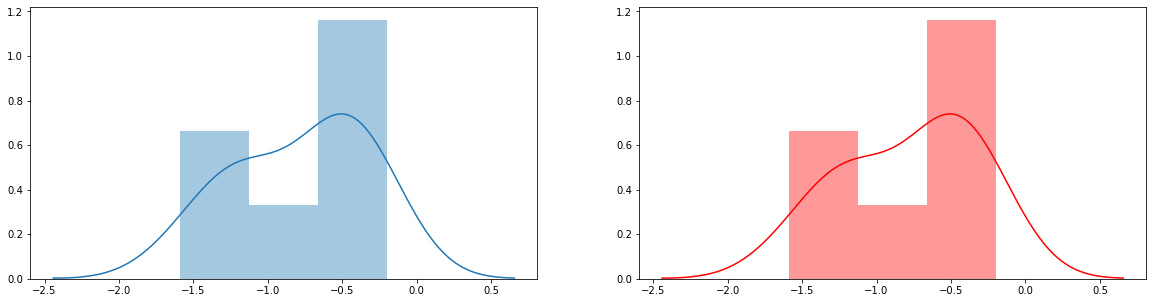

In [33]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(erros,ax=ax[0])
sns.distplot(erros1,ax=ax[1], color='red');

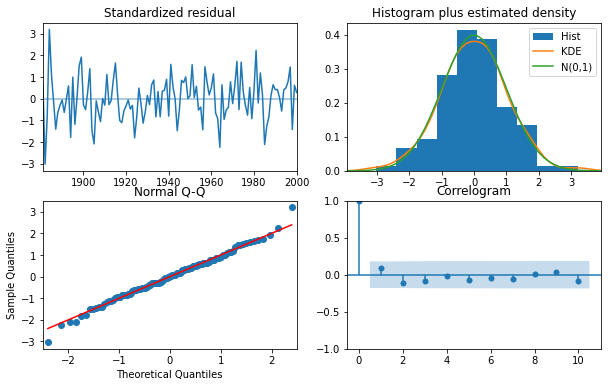

In [34]:
stepwise.plot_diagnostics(figsize=(10,6));

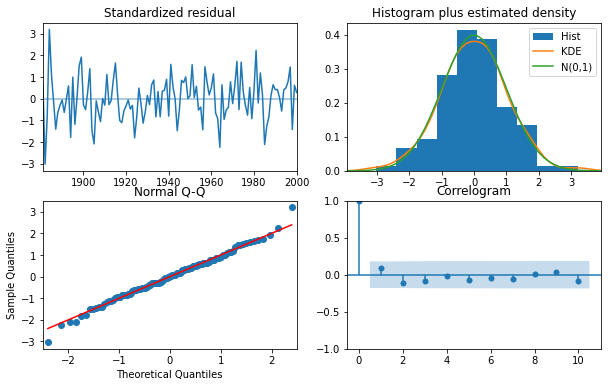

In [35]:
stepwise1.plot_diagnostics(figsize=(10,6));

In [36]:
# Verificado normalidade dos resíduos pelo teste Jarque Bera:
test = jarque_bera(erros)
print('Estatística Jarque-Bera :', test[0])
print('p-valor :', test[1])
print('Assimetria :', test[2])
print('Curtose :',test[3])

Estatística Jarque-Bera : [1.0148861]
p-valor : [0.60203298]
Assimetria : [-0.35610792]
Curtose : [1.8310755]


In [37]:
test1 = jarque_bera(erros1)
print('Estatística Jarque-Bera :', test1[0])
print('p-valor :', test1[1])
print('Assimetria :', test1[2])
print('Curtose :',test1[3])

Estatística Jarque-Bera : [1.0148861]
p-valor : [0.60203298]
Assimetria : [-0.35610792]
Curtose : [1.8310755]


In [38]:
stepwise1.fit(df_sea)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [43]:
future_forecast2=stepwise1.predict(n_periods=12)

In [44]:
uture_forecast2=pd.DataFrame(future_forecast2, 
                              index=pd.date_range(start='2013-01-01',
                                                  end='2017-01-01'),columns=['Nova previsão'])

In [45]:
future_forecast2.head(24)

2014-01-01    9.158584
2015-01-01    9.227147
2016-01-01    9.295709
2017-01-01    9.364272
2018-01-01    9.432834
2019-01-01    9.501397
2020-01-01    9.569959
2021-01-01    9.638522
2022-01-01    9.707084
2023-01-01    9.775647
2024-01-01    9.844209
2025-01-01    9.912772
Freq: AS-JAN, dtype: float64

<Figure size 1440x360 with 0 Axes>

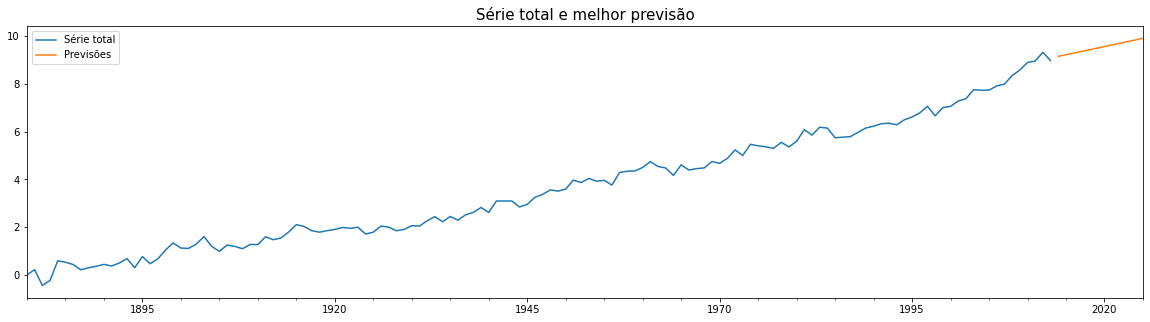

In [46]:
plt.figure(figsize=(20,5))
pd.concat([df_sea,future_forecast2],axis=1).plot(figsize=(20,5))
plt.xlabel('')
plt.title('Série total e melhor previsão',size=15)
plt.legend(['Série total','Previsões'])
plt.show();